# Heart disease: a longstanding, pressing health issue

Heart disease was considered the leading cause of death in the U.S. in 2020 by the Center of Disease Control. To reduce the public health risk heart disease can pose to populations and hospital infrastructure, governments and other authorities must be able to quantify this risk. In this exercise, we train two classification machine learning models to quantify heart disease susceptibility in a dataset. The findings may help us understand how to leverage machine learning in similar epidemiological applications.


In [1]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn
import xgboost as xgb
import lime
import lime.lime_tabular
import warnings
from seaborn import countplot
from matplotlib import rcParams
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from xgboost import XGBClassifier
from lime import submodular_pick

# Reading and Cleaning Dataset

The original dataset was pulled from Kaggle (originally posted by user fedesoriano). The raw dataset is a CSV with 918 observations and 12 features, including data from subjects pulled from five medical databases in North America and Europe. The target feature was called "HeartDisease" - in our models, we will be employing ensemble methods to classify observations as 1 (having heart disease) or 0 (not having heart disease), as displayed in this column.

In [2]:
# Read in the data from the CSV file

df = pd.read_csv('heart.csv')

In [3]:
# Determine number of rows and columns

df.shape

(918, 12)

In [4]:
# Get a snapshot of the first 5 rows of data

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
# Understand non-null values and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Prior to performing EDA, rows with 0 values for RestingBP, Cholesterol, and MaxHR features are removed. Additionally, age data was categorized into 10-year buckets to limit cardinality.

In [6]:
# Drop rows for which blood pressure, cholesterol, and maximum heart rate values are 0.

df = df[(df[['RestingBP', 'Cholesterol', 'MaxHR']] != 0).all(1)]

df.shape

(746, 12)

In [7]:
# Aggregate missing values by column

df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
# Understand maximum, minimum values in the age column

df['Age'].describe()

count    746.000000
mean      52.882038
std        9.505888
min       28.000000
25%       46.000000
50%       54.000000
75%       59.000000
max       77.000000
Name: Age, dtype: float64

In [9]:
# Create 'Age_Decade' column that bins ages roughly by decade. Follows common health age group classification practices

df['Age_Decade'] = pd.cut(x=df['Age'], bins=[25, 34, 44, 54, 64, 74, 84], labels=['25-34', '35-44', '45-54', '55-64', '65-74', '75-84'])

# EDA

As a first step in our EDA, we generated histograms of the features containing numerical data. As seen below, the Oldpeak column histogram has a more prominent tail than the other graphs do. 13 rows in the original dataset that had negative values in this column. Since these rows also had a 0 cholesterol value, they were removed from the final dataset used for analysis.  We can potentially address this by applying a log transformation.

The other graphs have unique characteristics but visually appear to more closely resemble a normal distribution than the Oldpeak graph does. 


array([[<AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>]], dtype=object)

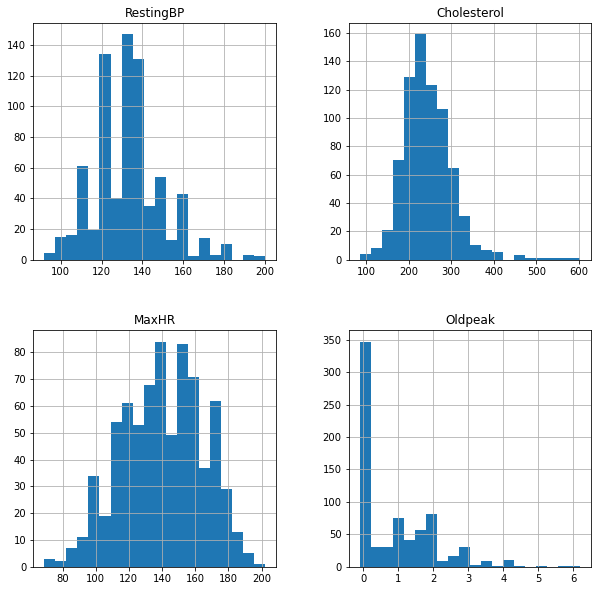

In [10]:
# Create histograms of columns containing numerical data (not categorical data)

df_numeric = df[['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]

df_numeric.hist(figsize=(10, 10), bins=20)

We then shift our focus to the categorical columns.

In [11]:
# Create new dataframe of only categorical data from the original dataset

df_categorical = df[['Age_Decade', 'Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']]

categorical_cols = list(df_categorical.columns)

In [12]:
# Understand the unique values in the categorical data columns - assessing cardinality

for col in df_categorical:
    print(col, df_categorical[col].unique())

Age_Decade ['35-44', '45-54', '55-64', '25-34', '65-74', '75-84']
Categories (6, object): ['25-34' < '35-44' < '45-54' < '55-64' < '65-74' < '75-84']
Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS [0 1]
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']
HeartDisease [0 1]


In [13]:
# Rename certain values in categorical data columns for interpretability

df_categorical['FastingBS'] = df_categorical['FastingBS'].replace([0,1],['Below 120mg/dl', 'Above 120mg/dl'])
df_categorical['ExerciseAngina'] = df_categorical['ExerciseAngina'].replace(['N','Y'],['No', 'Yes'])
df_categorical['HeartDisease']= df_categorical['HeartDisease'].replace([0,1],['No', 'Yes'])


df['FastingBS'] = df['FastingBS'].replace([0,1],['Below 120mg/dl', 'Above 120mg/dl'])
df['ExerciseAngina'] = df['ExerciseAngina'].replace(['N','Y'],['No', 'Yes'])
df['HeartDisease']= df['HeartDisease'].replace([0,1],['No', 'Yes'])


<ipython-input-13-88148e0e8552>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['FastingBS'] = df_categorical['FastingBS'].replace([0,1],['Below 120mg/dl', 'Above 120mg/dl'])
<ipython-input-13-88148e0e8552>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['ExerciseAngina'] = df_categorical['ExerciseAngina'].replace(['N','Y'],['No', 'Yes'])
<ipython-input-13-88148e0e8552>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

We can make the following observations in the subsequent box plots:

 - Most subjects in the dataset are between 44 and 65
 - There are over twice as many male subjects as female subjects
 - Most subjects do not report chest pain symptoms or exercise induced angina
 - Far more subjects had a fasting blood sugar below 120mg/dl than above 120mg/dl
 - Most subjects appeared to have a normal electrocardiogram reading, though the ST segment for the vast majority of subjects was flat or trending upward
 - Heart disease was detected in nearly half of the subjects

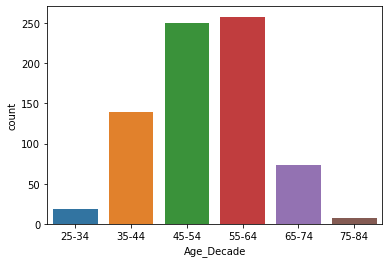

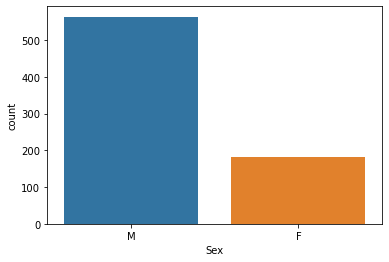

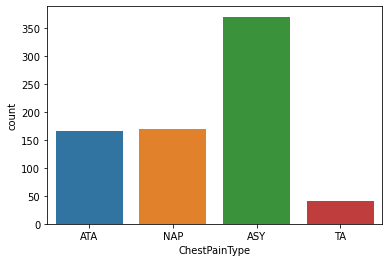

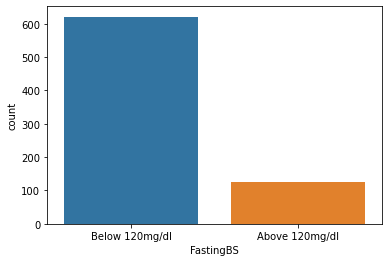

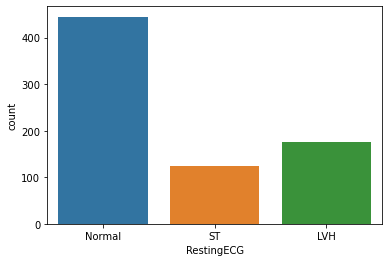

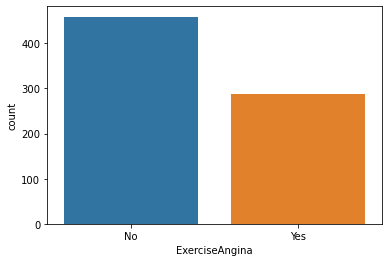

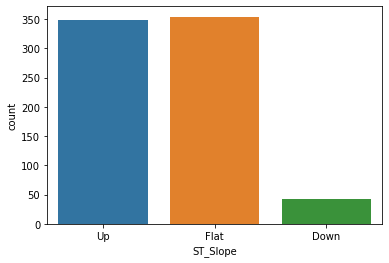

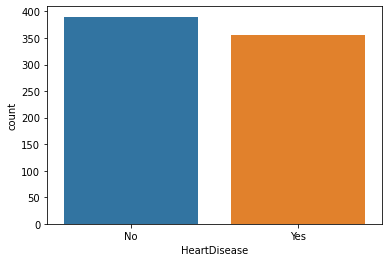

In [14]:
# Create count plots of categorical data columns

for col in categorical_cols:
    sns.countplot(x = col, data = df_categorical)
    plt.show()

In the following boxplot, there seem to be far more outliers in the Cholesterol feature than in other features. This could, however, be primarily due to the scale of the graph.

<AxesSubplot:>

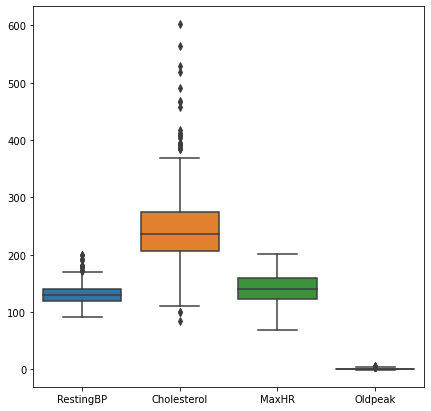

In [15]:
# Create a boxplot of numerical data columns

rcParams['figure.figsize'] = 7, 7

sns.boxplot(data=df_numeric)

In the following scatter plots, we explore the relationships between multiple numerical features, while providing insight on presence of heart disease. In each, there does not seem to be a strong correlation present in either graph, although the presence of heart disease does seem to increase as Age increases in both graphs.

[Text(0.5, 1.0, 'RestingBP vs Age')]

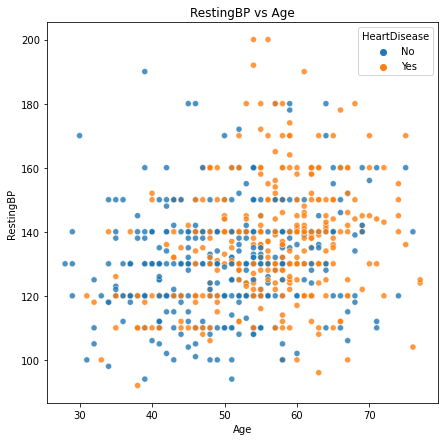

In [16]:
# Create a scatter plot to understand any relationship among the Age, RestingBP, and HeartDisease features

rcParams['figure.figsize'] = 7, 7

sns.scatterplot(data=df, x="Age", y="RestingBP", hue="HeartDisease", alpha=0.8).set(title='RestingBP vs Age')


[Text(0.5, 1.0, 'Cholesterol vs Age')]

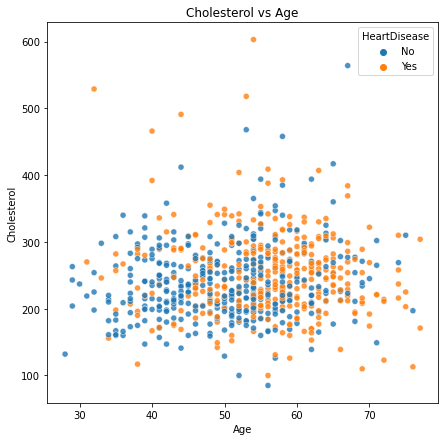

In [17]:
# Create a scatter plot to understand any relationship among the Age, Cholesterol, and HeartDisease features

rcParams['figure.figsize'] = 7, 7

sns.scatterplot(data=df, x="Age", y="Cholesterol", hue="HeartDisease", alpha=0.8).set(title='Cholesterol vs Age')

# Feature Engineering

After EDA, we've dropped rows containing numerical data more than 3 standard deviations from each column's respective mean. Additionally, we've performed one-hot encoding on the features containing categorical data. Finally, in preparation for modeling, we've created training and testing datasets. 

In [18]:
# Drop rows in which numerical data is outside 3 standard deviations from the mean for that column

for col in df_numeric.columns:
    df_numeric = df_numeric[np.abs(df_numeric[col]-df_numeric[col].mean()) <= (3*df_numeric[col].std())]
    df[col] = df_numeric[col]
    
df = df.dropna()

In [19]:
# Group features for one-hot encoding

obj_cols = list(df.select_dtypes(include=object).columns)

obj_cols.remove('HeartDisease')

obj_cols.append('Age_Decade')

for col in obj_cols:
    print(col, df[col].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS ['Below 120mg/dl' 'Above 120mg/dl']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['No' 'Yes']
ST_Slope ['Up' 'Flat' 'Down']
Age_Decade ['35-44', '45-54', '55-64', '25-34', '65-74', '75-84']
Categories (6, object): ['25-34' < '35-44' < '45-54' < '55-64' < '65-74' < '75-84']


In [20]:
# Perform one-hot encoding

df = pd.get_dummies(df, columns=list(obj_cols))

In [21]:
# Drop the age column. Print column names for the updated dataframe

df = df.drop(columns=['Age'])

df.columns

Index(['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease', 'Sex_F',
       'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'FastingBS_Above 120mg/dl',
       'FastingBS_Below 120mg/dl', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ExerciseAngina_No', 'ExerciseAngina_Yes',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'Age_Decade_25-34',
       'Age_Decade_35-44', 'Age_Decade_45-54', 'Age_Decade_55-64',
       'Age_Decade_65-74', 'Age_Decade_75-84'],
      dtype='object')

In [22]:
# Aggregate missing values by column

df.isna().sum()

RestingBP                   0
Cholesterol                 0
MaxHR                       0
Oldpeak                     0
HeartDisease                0
Sex_F                       0
Sex_M                       0
ChestPainType_ASY           0
ChestPainType_ATA           0
ChestPainType_NAP           0
ChestPainType_TA            0
FastingBS_Above 120mg/dl    0
FastingBS_Below 120mg/dl    0
RestingECG_LVH              0
RestingECG_Normal           0
RestingECG_ST               0
ExerciseAngina_No           0
ExerciseAngina_Yes          0
ST_Slope_Down               0
ST_Slope_Flat               0
ST_Slope_Up                 0
Age_Decade_25-34            0
Age_Decade_35-44            0
Age_Decade_45-54            0
Age_Decade_55-64            0
Age_Decade_65-74            0
Age_Decade_75-84            0
dtype: int64

In [23]:
# Revisit HeartDisease column - change values back to 0 and 1 for modeling. Split data into X and y dataframes.

df_y = df['HeartDisease'].replace(['No', 'Yes'],[0,1])


df_X = df.drop(columns=['HeartDisease'])

In [24]:
# Split data into training and testing datasets

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_X, df_y, test_size=0.33, random_state=42, stratify=df_y)

In [25]:
# Determine splitting between HeartDisease and No HeartDisease in y dataframe

df_y.value_counts()/len(df_y)

0    0.529574
1    0.470426
Name: HeartDisease, dtype: float64

In [26]:
# Assess stratification of target variable classes in training and testing datasets

print(y_train.value_counts()/len(y_train))

print(y_test.value_counts()/len(y_test))

0    0.529774
1    0.470226
Name: HeartDisease, dtype: float64
0    0.529167
1    0.470833
Name: HeartDisease, dtype: float64


In [27]:
# Set up scaling and XGBoost pipeline

model_x = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42, use_label_encoder=False)

xgb_pipe = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('classifier', model_x)
])

xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='aucpr', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, seed=42, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                      

# Modeling

Next, we set up pipelines for our models. The first model leverages Extreme Gradient Boosting. As seen in the confusion matrix below, this model generated 15 false positives and 17 false negatives. Consequently, the model achieved a precision metric of 86.5% and a recall metric of 85.0% In this context, we would like to focus on recall for evaluating our model's performance.


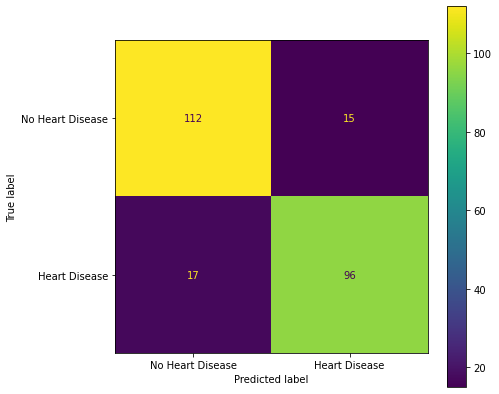

In [28]:
# Print confusion matrix for XGBoost model

xgb_pred = xgb_pipe.predict(X_test)
cm = metrics.confusion_matrix(y_test, xgb_pred, labels=xgb_pipe.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot()
plt.show()

In [29]:
# Print precision and recall metrics

xgb_precision = metrics.precision_score(y_test, xgb_pred)
xgb_recall = metrics.recall_score(y_test, xgb_pred)

print('XGBoost Model Precision:', format(xgb_precision, '.1%'), '\nXGBoost Model Recall: ', format(xgb_recall, '.1%'))

XGBoost Model Precision: 86.5% 
XGBoost Model Recall:  85.0%


We used multiple methods to determine the importance of features, relative to one another, for classifying subjects as having heart disease or not. The first employed mean decrease in impurity, which highlights the one-hot encoded column for ST_Slope_Up as being markedly more important than the remaining columns. This approach is less reliable for high-cardinality data, but it does provide some insight into the importance of our categorical variables.

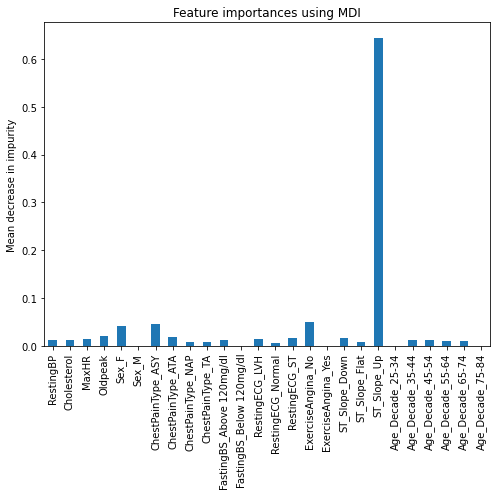

In [30]:
# Estimate feature importance using mean decrease in impurity

feature_names = df_X.columns
importances = model_x.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The second approach leveraged LIME - local interpretable model-agnostic explanations. The below images compare feature importances for individual classifications made by the XGBoost classifier. ST_Slope_Up has again appeared as the most important feature, as having a positive value in this column has classified this observation as not having heart disease.


In [31]:
# Create object of LimeTabularExplainer class, fit to training data

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.array(X_train), 
                                                   mode='classification',
                                                   feature_names=df_X.columns,
                                                   categorical_features=[5, len(X_train.columns)],
                                                   verbose=True,
                                                   random_state=42)

In [32]:
# Use LimeTabularExplainer to explain one instance of testing data

exp = explainer.explain_instance(data_row=X_test.iloc[3], 
                                 predict_fn=xgb_pipe.predict_proba, 
                                 num_features=5)

exp.show_in_notebook(show_table=True)

Intercept 0.6292792441907499
Prediction_local [-0.06479101]
Right: 0.030470926


In [33]:
# Code for SP-LIME, which returns exaplanations on a sample set to provide a non redundant global decision boundary of original model

sp_obj_xgb = submodular_pick.SubmodularPick(explainer, X_train.values, xgb_pipe.predict_proba, sample_size=100, num_features=10, num_exps_desired=5)

Intercept 0.7943143518780968
Prediction_local [0.50562073]
Right: 0.947933
Intercept 0.2259849307433901
Prediction_local [0.95647383]
Right: 0.9922649
Intercept 0.11967047124802677
Prediction_local [0.84240622]
Right: 0.9808648
Intercept 0.04962083577446735
Prediction_local [0.73160652]
Right: 0.99241394
Intercept -0.22390606203410146
Prediction_local [1.15075589]
Right: 0.9996848
Intercept -0.03845959418782119
Prediction_local [0.99276896]
Right: 0.99883646
Intercept 0.31378456716182335
Prediction_local [0.76350029]
Right: 0.9694031
Intercept 0.2142715983589567
Prediction_local [0.82425459]
Right: 0.9944378
Intercept 1.0785229899123583
Prediction_local [-0.01055736]
Right: 0.95883733
Intercept 0.9575539397455101
Prediction_local [0.04047468]
Right: 0.94306344
Intercept 0.103828190063184
Prediction_local [1.01103252]
Right: 0.99495083
Intercept 1.0985483942177923
Prediction_local [-0.13627886]
Right: 0.81632966
Intercept 0.06980767495786067
Prediction_local [1.15391467]
Right: 0.984064

[<Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>]

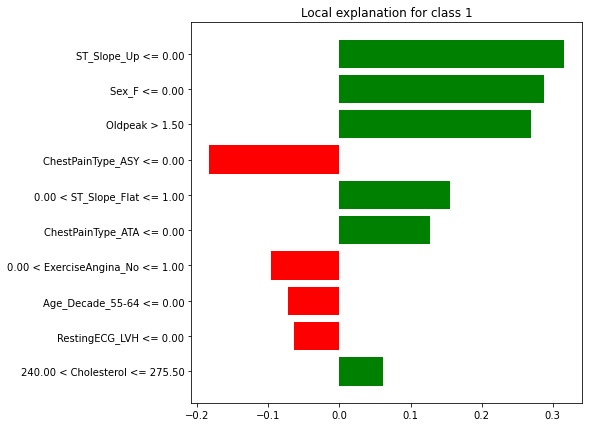

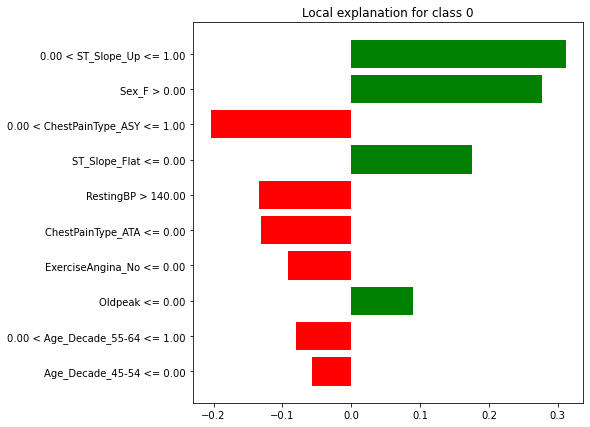

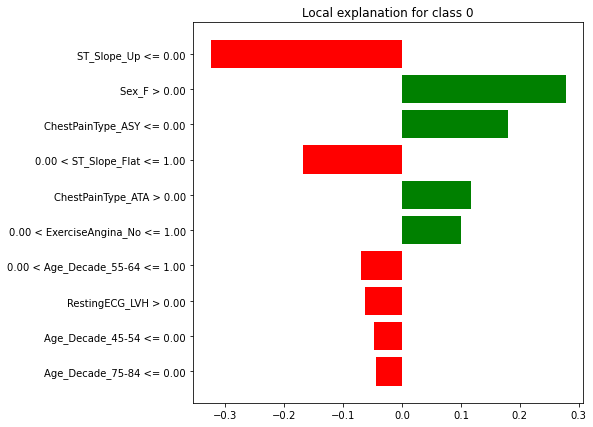

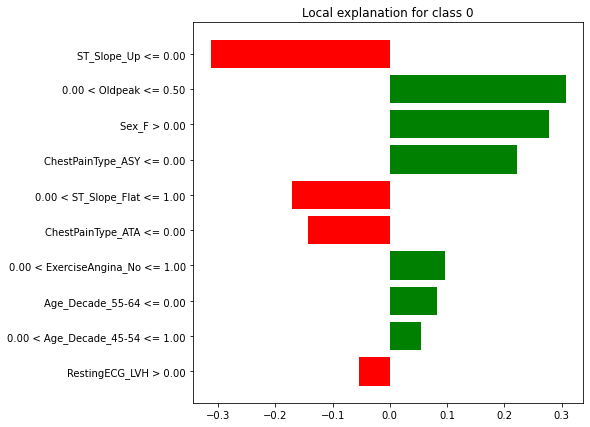

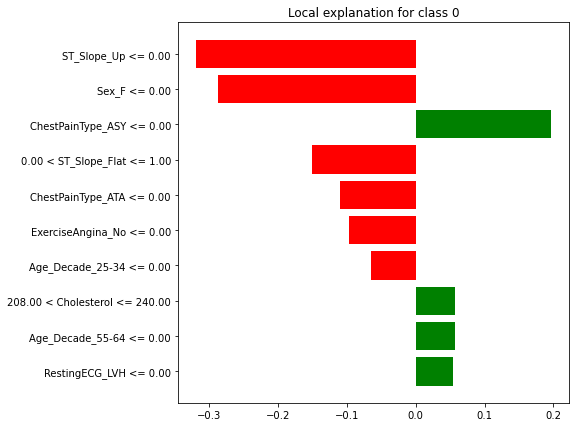

In [34]:
# Plot explainations for representative samples

[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj_xgb.sp_explanations]



The second model uses the random forest classification methodology. Doing so achieved a precision metric of 87.0% and a recall metric of 88.5%, a higher degree of performance than our last model. As seen in the subsequent step, the hyperparameters for this model were hardcoded, but we may be able to obtain more improved performance by tuning these hyperparameters with GridSearchCV or RandomizedSearchCV.


In [35]:
# Set up a RandomForestClassifier pipeline

model_r = ensemble.RandomForestClassifier(max_depth = 10,
                                          min_samples_leaf = 3,
                                          min_samples_split = 4,
                                          n_estimators = 200)

rfc_pipe = pipeline.Pipeline([
     ('scaler', preprocessing.StandardScaler()), 
     ('classifier', model_r)
])

rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=4,
                                        n_estimators=200))])

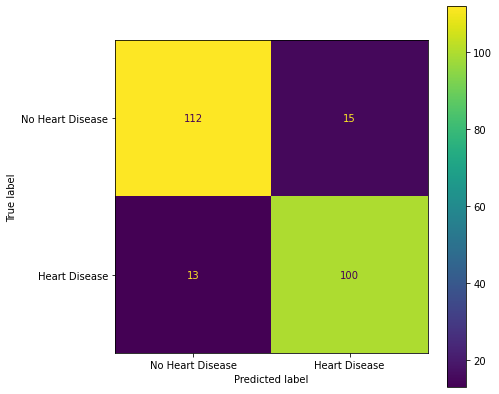

In [36]:
# Print confusion matrix for RandomForestClassifier model

rfc_pred = rfc_pipe.predict(X_test)
cm = metrics.confusion_matrix(y_test, rfc_pred, labels=rfc_pipe.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot()
plt.show()

In [37]:
# Print precision and recall metrics

rfc_precision = metrics.precision_score(y_test, rfc_pred)
rfc_recall = metrics.recall_score(y_test, rfc_pred)

print('RandomForestClassifier Model Precision:', format(rfc_precision, '.1%'), '\nRandomForestClassifier Model Recall: ', format(rfc_recall, '.1%'))

RandomForestClassifier Model Precision: 87.0% 
RandomForestClassifier Model Recall:  88.5%


As shown below, LIME has identified ST_Slope_Up as being important for classification relative to the other features in the context of the random forest model as well.

In [38]:
# Use LimeTabularExplainer to explain one instance of testing data

exp_rfc = explainer.explain_instance(data_row=X_test.iloc[3], 
                                    predict_fn=rfc_pipe.predict_proba, 
                                    num_features=5)

exp.show_in_notebook(show_table=True)

Intercept 0.694447873892458
Prediction_local [0.24380936]
Right: 0.18230102194033432


In [39]:
# Code for SP-LIME, which returns exaplanations on a sample set to provide a non redundant global decision boundary of original model

sp_obj_rfc = submodular_pick.SubmodularPick(explainer, X_train.values, rfc_pipe.predict_proba, sample_size=100, num_features=10, num_exps_desired=5)

Intercept 0.278646005086199
Prediction_local [0.6080641]
Right: 0.7926571843189493
Intercept 0.3017473182013487
Prediction_local [0.85396402]
Right: 0.9940387622035418
Intercept 0.0036116354163919784
Prediction_local [0.86222112]
Right: 0.9812614030255759
Intercept 0.17014246419589818
Prediction_local [0.69445914]
Right: 0.6408580023899753
Intercept 0.3695269113977653
Prediction_local [0.46848662]
Right: 0.5899314486167428
Intercept 0.38971321048566854
Prediction_local [0.77956769]
Right: 0.6405813903309351
Intercept 0.2965590185037634
Prediction_local [0.85408935]
Right: 0.8658398293981212
Intercept 0.303163742462871
Prediction_local [0.85501116]
Right: 0.8920488531982592
Intercept 0.5419166623529785
Prediction_local [0.62649221]
Right: 0.8325055573523568
Intercept -0.04022742327254186
Prediction_local [0.95246505]
Right: 0.8971071729081287
Intercept 0.30331833703323396
Prediction_local [0.85799875]
Right: 0.9753786017726236
Intercept -0.02524117876132287
Prediction_local [0.89473195]

Intercept 0.8631138179261224
Prediction_local [0.3557425]
Right: 0.5246362358655837
Intercept 0.2346325730691649
Prediction_local [0.67729995]
Right: 0.7711753499768206
Intercept -0.04299104920319696
Prediction_local [0.96090318]
Right: 0.9707419082024478
Intercept 0.285379169002989
Prediction_local [0.58545591]
Right: 0.7125512609371303


[<Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>]

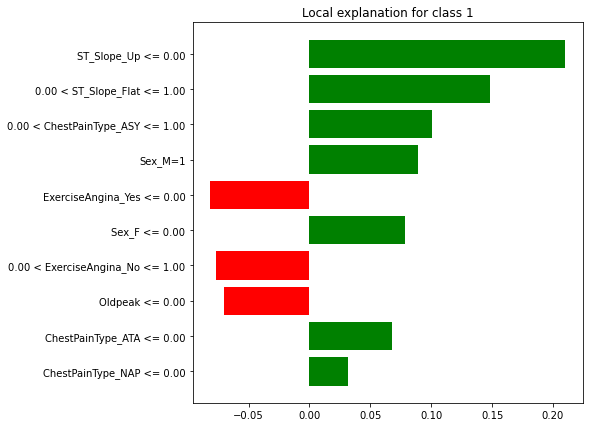

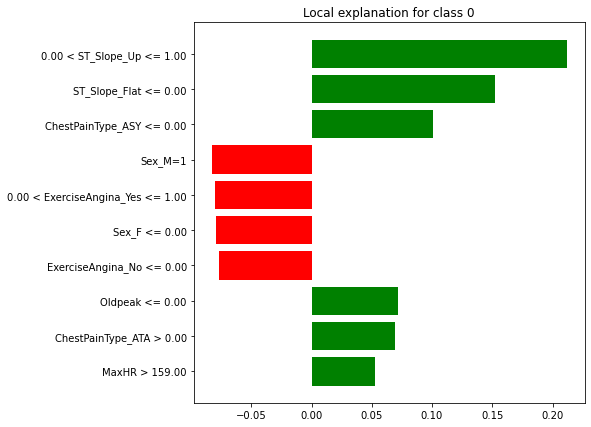

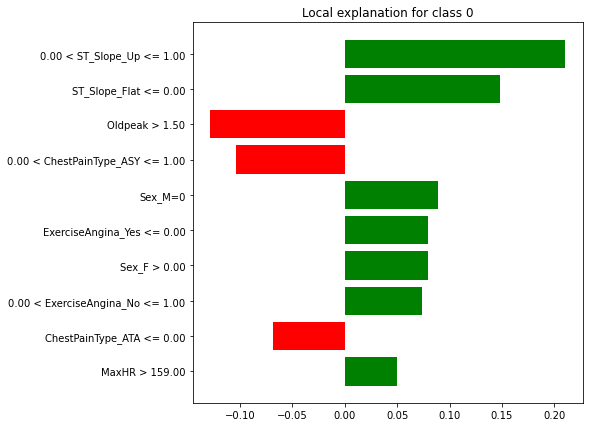

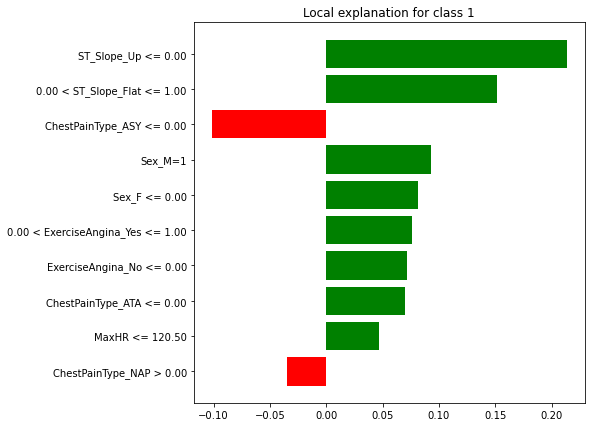

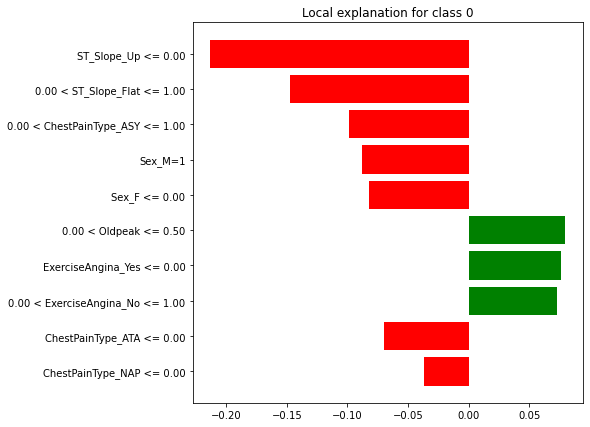

In [40]:
# Plot explainations for representative samples

[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj_rfc.sp_explanations]

# Conclusions

We've successfully made two models to predict the presence of heart disease in populations using classification machine learning models. Our random forest model achieved the better performance of both, with a recall score of 88.5%. As a next step, we can apply a log transformation to the Oldpeak values, tune the hyperparameters for the random forest model, and explore more medical datasets to assess the relative importance of other demographic/clinical traits in such exercises. Doing so may help us more closely tailor these models to be used to track heart disease in today's world.